In [1]:
import sys
sys.path.append("/home/paj7rng/workspace/mobo_experiments")


In [2]:
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.test_functions.multi_objective import GMM, BraninCurrin
from botorch.utils.multi_objective.box_decompositions.dominated import DominatedPartitioning
from botorch.utils.multi_objective.box_decompositions.non_dominated import FastNondominatedPartitioning

from benchmarks.rover import Rover

tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cpu"),
}
SEED = 42
# Setting seed for reproducibility
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

In [3]:
# define problem
problem = BraninCurrin(negate=True).to(**tkwargs)
# problem = GMM(negate=True).to(**tkwargs)
# problem.ref_point = torch.tensor([-250., -10.], **tkwargs)

## Problem

The approximated pareto set and pareto front is shown in the following figure.

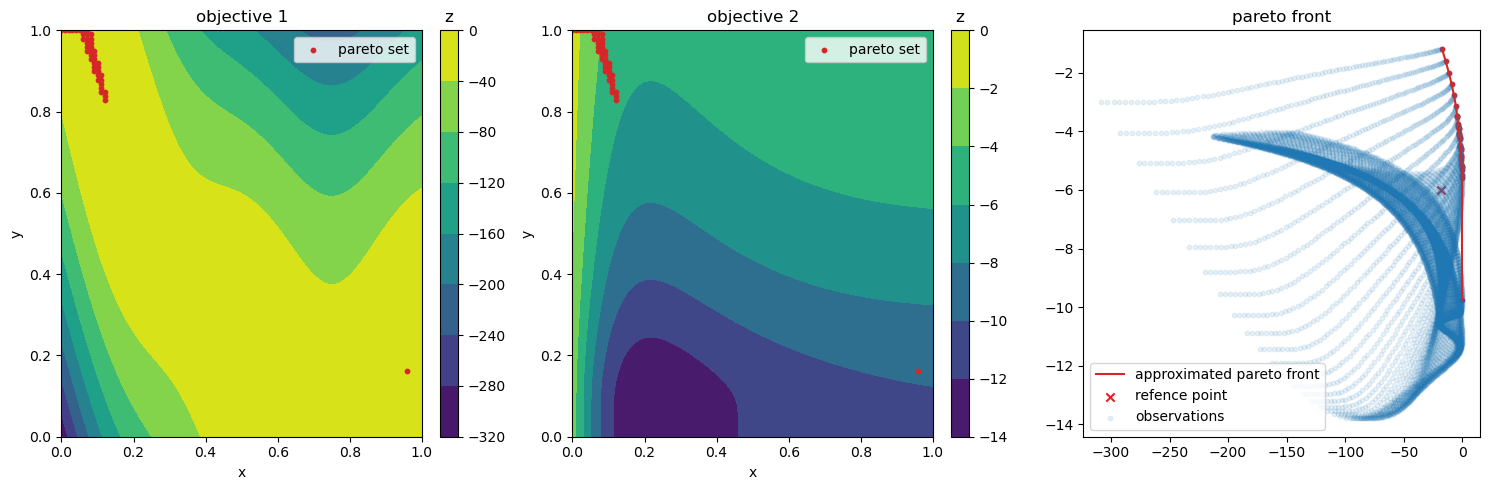

In [4]:
from plot_utils import plot_objective

plot_objective(problem, num_samples=100)

In [5]:
def generate_initial_data(problem, n=6):
    # generate training data
    train_x = draw_sobol_samples(bounds=problem.bounds, n=n, q=1).squeeze(1)
    train_obj = problem(train_x)
    return train_x, train_obj

In [6]:
init_x, init_y = generate_initial_data(problem, n=6)

## Generate data

In [7]:
from optimizers.mbore.mbore_mdre_aux_hv_09 import MBORE_MDRE_AUX_HV_09

In [8]:
def plot_input_space(xx, yy, x_obs, preds, fig, ax, title=None):
    div = make_axes_locatable(ax)
    cax = div.append_axes('right', '5%', '5%')

    # plot functions
    countourset = ax.contourf(
        xx,
        yy,
        preds.reshape(xx.shape),
    )
    ax.scatter(*x_obs.t(), alpha=0.3, s=10, color='tab:red')

    cax.grid(False)  # just to remove the warning
    clb = fig.colorbar(countourset, cax=cax)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title(title)
    clb.ax.set_title('z')


def plot_pareto_space(y_obs, pareto, l, u_nbd, ax, title='pareto'):
    ax.scatter(*y_obs[~pareto].t(), s=10, alpha=0.3)
    ax.scatter(*l.t(), s=10, color='tab:red', label="pareto")
    ax.plot(*l.t(), color='tab:red')
    # ax.scatter(*u_nbd.t(), s=10, label="non dominated", color='tab:purple')
    ax.scatter(*problem.ref_point.t(), s=10, color='k', label="ref point")

    ax.set_xlabel('y1')
    ax.set_ylabel('y2')
    ax.set_title(title)
    ax.legend()


def plot_pareto_box(tau, boxes, ax):
    ax.scatter(*tau.t(), label=r"$\mathbf{\tau}$")
    pc = PatchCollection(boxes, cmap='tab10', alpha=.3)
    pc.set_array(torch.arange(0, len(boxes)))
    ax.add_collection(pc)
    x_lim = ax.get_xlim()
    y_lim = ax.get_ylim()
    ax.axvspan(x_lim[0], tau[0], alpha=0.1, color='tab:gray')
    ax.axhspan(y_lim[0], tau[1], alpha=0.1, color='tab:gray')
    ax.set_xlim(*x_lim)
    ax.set_ylim(*y_lim)

In [9]:
x_obs = init_x
y_obs = init_y

num_obj = problem.num_objectives
# only plot the first two dimensions
xx, yy = np.meshgrid(
    np.linspace(
        *problem.bounds.t()[0], 100
    ),
    np.linspace(
        *problem.bounds.t()[1], 100
    ),
)
x_cands = np.vstack((xx.flatten(), yy.flatten())).T
x_cands = torch.from_numpy(x_cands).to(**tkwargs)
y_cands = problem(x_cands).reshape(100, 100, num_obj)
xx_obj, yy_obj = y_cands[:, :, 0], y_cands[:, :, 1]

2024-06-04 15:30:19,421 | optimizers.mbore.mbore_mdre_aux_hv_09


Iteration 0
pareto hv: 6.578558781234511
shell hv: 1.0000001654807488e-18
hv ratio: 1.5200900360323177e-19


100%|██████████| 1000/1000 [00:01<00:00, 585.23it/s]
2024-06-04 15:30:21,351 | Model fitting takes 1.93s
2024-06-04 15:30:21,355 | Optimizing the acquisition function takes 0.00s


total variance: 7.212905939692949
local variance: nan
variance ratio: nan


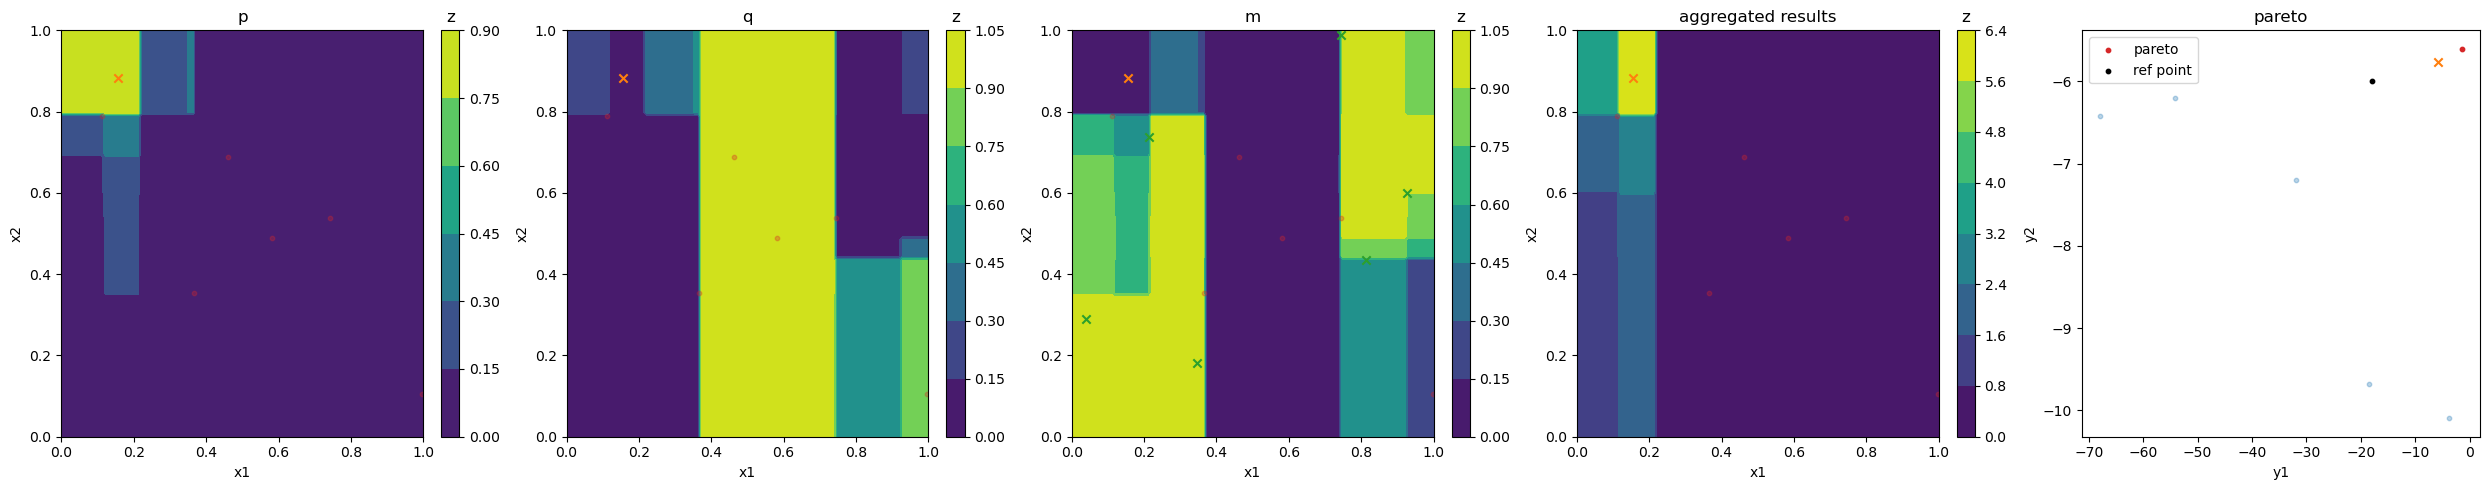

Iteration 1
pareto hv: 6.578558781234511
shell hv: 2.9556086191068442
hv ratio: 0.4492790468845221


100%|██████████| 1000/1000 [00:01<00:00, 629.14it/s]
2024-06-04 15:30:24,001 | Model fitting takes 1.61s
2024-06-04 15:30:24,006 | Optimizing the acquisition function takes 0.00s


total variance: 12.891840173178815
local variance: 21.638717819078845
variance ratio: 1.6784817007038073


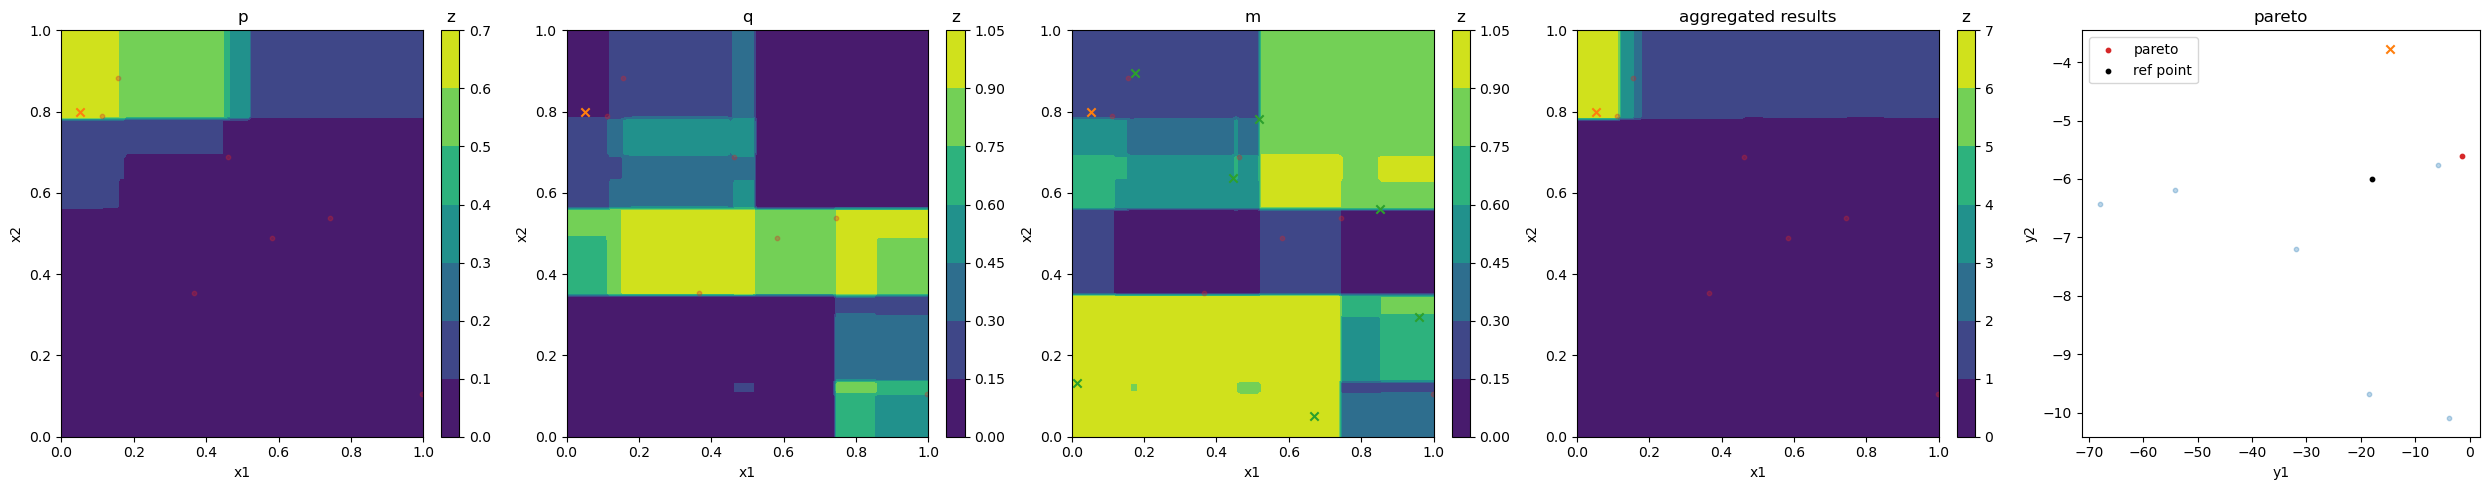

Iteration 2
pareto hv: 12.6904001453412
shell hv: 2.9556086191068442
hv ratio: 0.2329011367062278


100%|██████████| 1000/1000 [00:01<00:00, 613.94it/s]
2024-06-04 15:30:26,459 | Model fitting takes 1.65s
2024-06-04 15:30:26,464 | Optimizing the acquisition function takes 0.00s


total variance: 15.31321741676218
local variance: 10.950546461961885
variance ratio: 0.7151042242745916


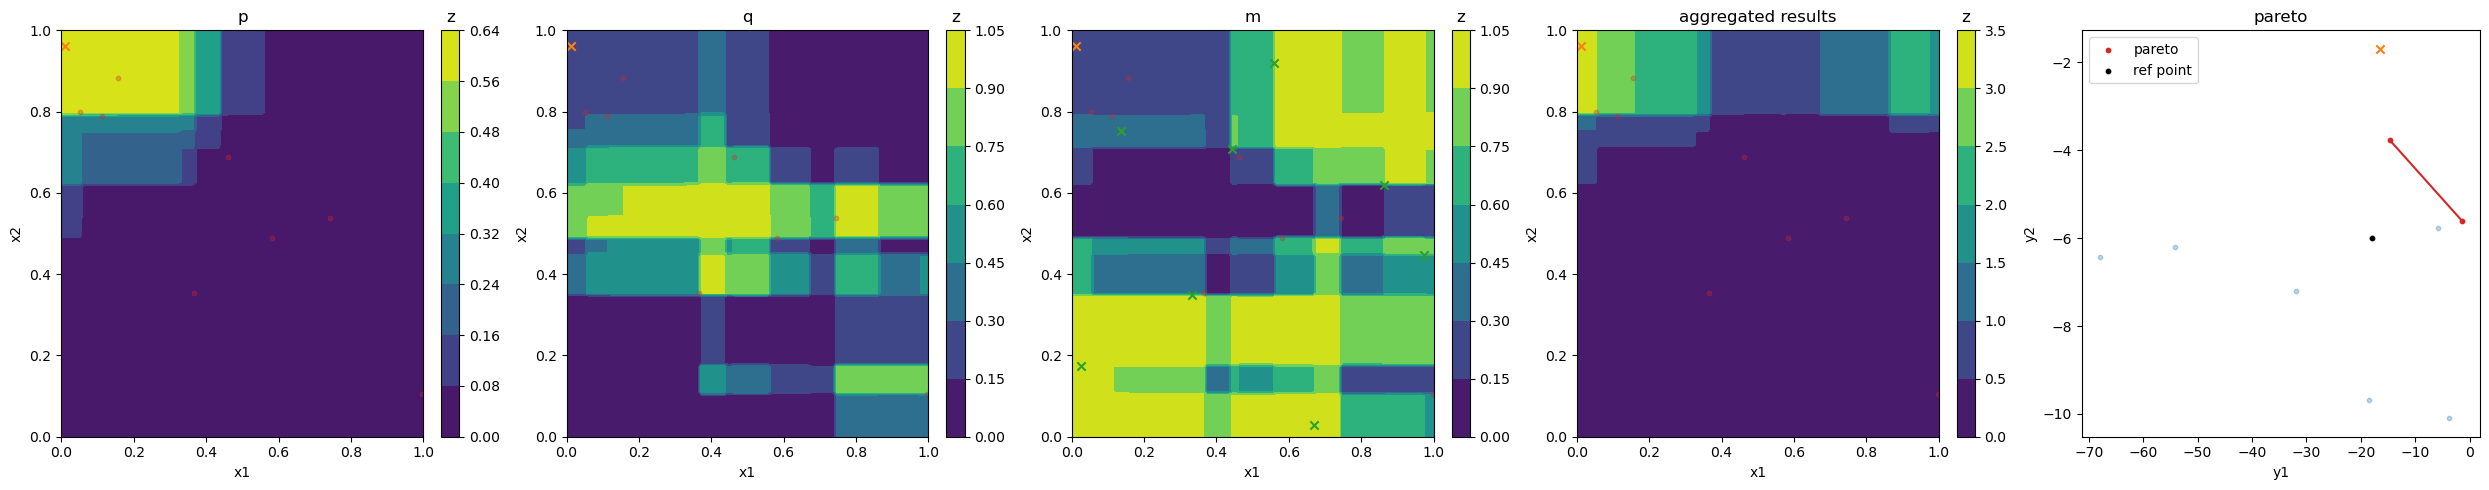

Iteration 3
pareto hv: 15.965623305870556
shell hv: 2.9556086191068442
hv ratio: 0.18512328410128953


100%|██████████| 1000/1000 [00:01<00:00, 613.83it/s]
2024-06-04 15:30:28,900 | Model fitting takes 1.65s
2024-06-04 15:30:28,907 | Optimizing the acquisition function takes 0.01s


total variance: 11.427083374389797
local variance: 1.339265562750716
variance ratio: 0.11720099686611697


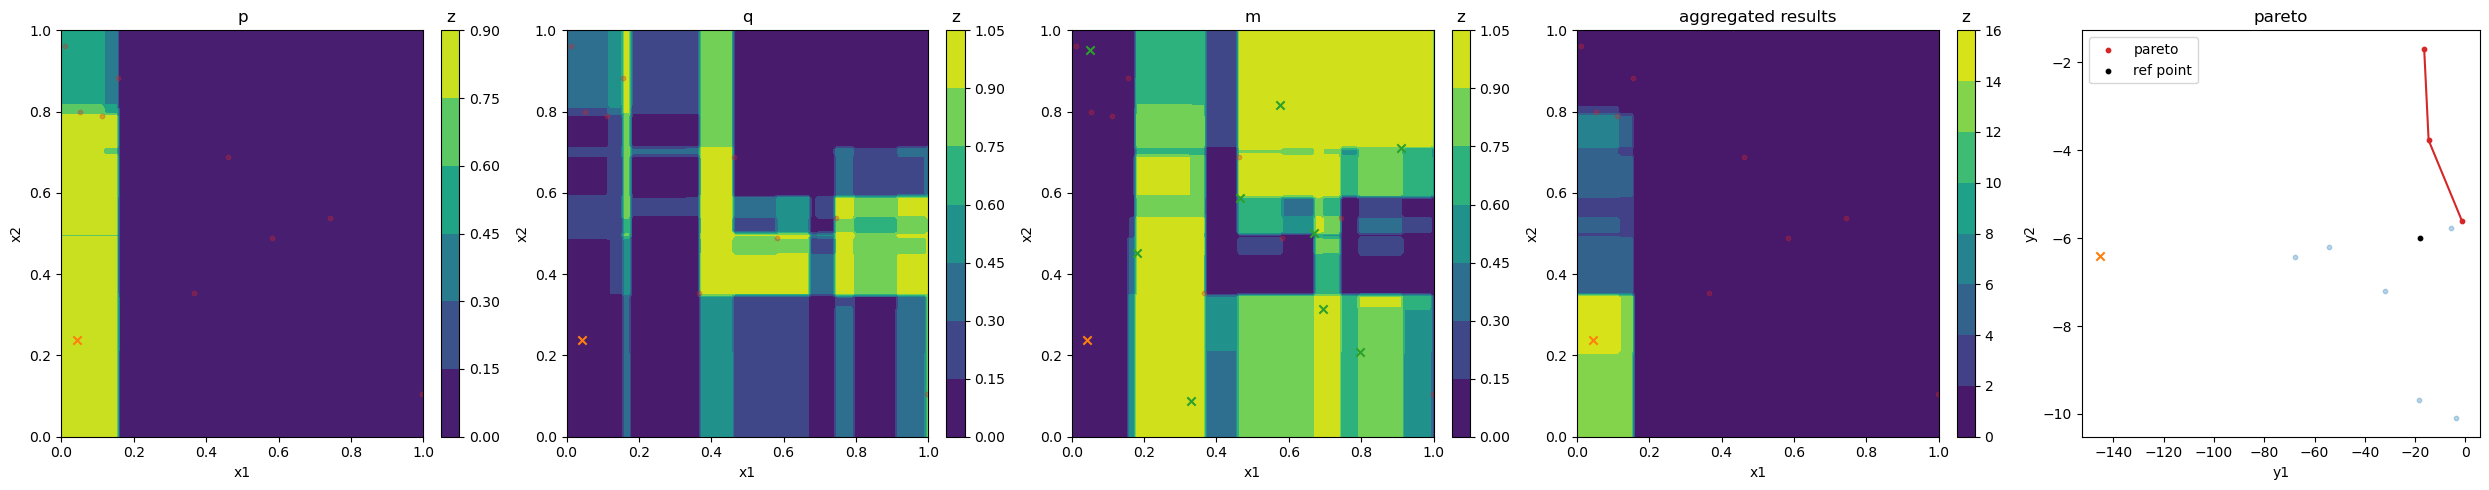

Iteration 4
pareto hv: 15.965623305870556
shell hv: 2.9556086191068442
hv ratio: 0.18512328410128953


100%|██████████| 1000/1000 [00:01<00:00, 536.97it/s]
2024-06-04 15:30:31,622 | Model fitting takes 1.88s
2024-06-04 15:30:31,628 | Optimizing the acquisition function takes 0.00s


total variance: 10.843803702806122
local variance: 1.339265562750716
variance ratio: 0.1235051462988163


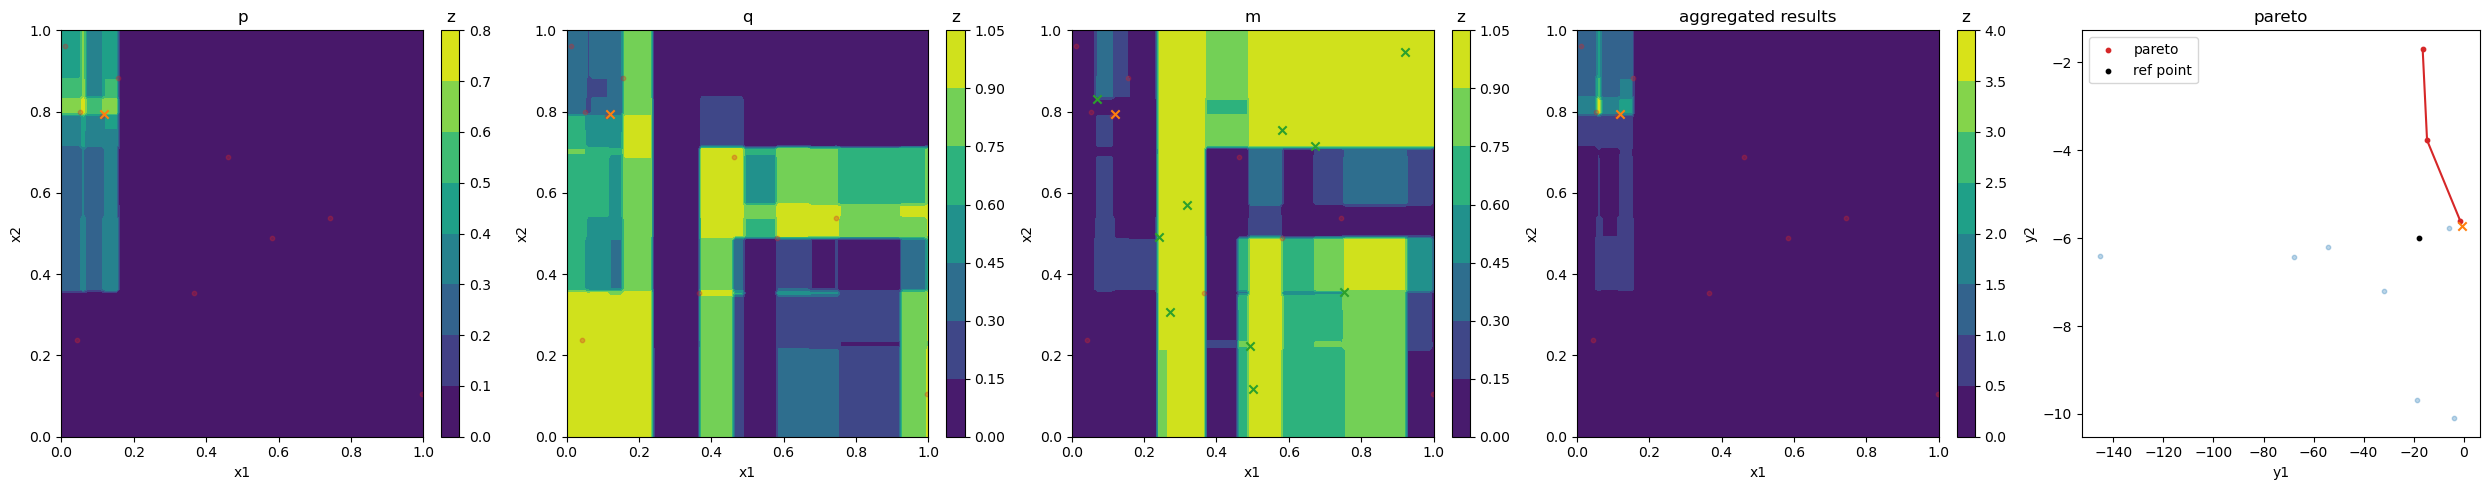

Iteration 5
pareto hv: 16.154792596425562
shell hv: 2.9556086191068442
hv ratio: 0.18295552861265502


100%|██████████| 1000/1000 [00:01<00:00, 655.14it/s]
2024-06-04 15:30:33,991 | Model fitting takes 1.55s
2024-06-04 15:30:33,997 | Optimizing the acquisition function takes 0.00s


total variance: 6.7943029597774
local variance: 2.1894140270432962
variance ratio: 0.3222426259183219


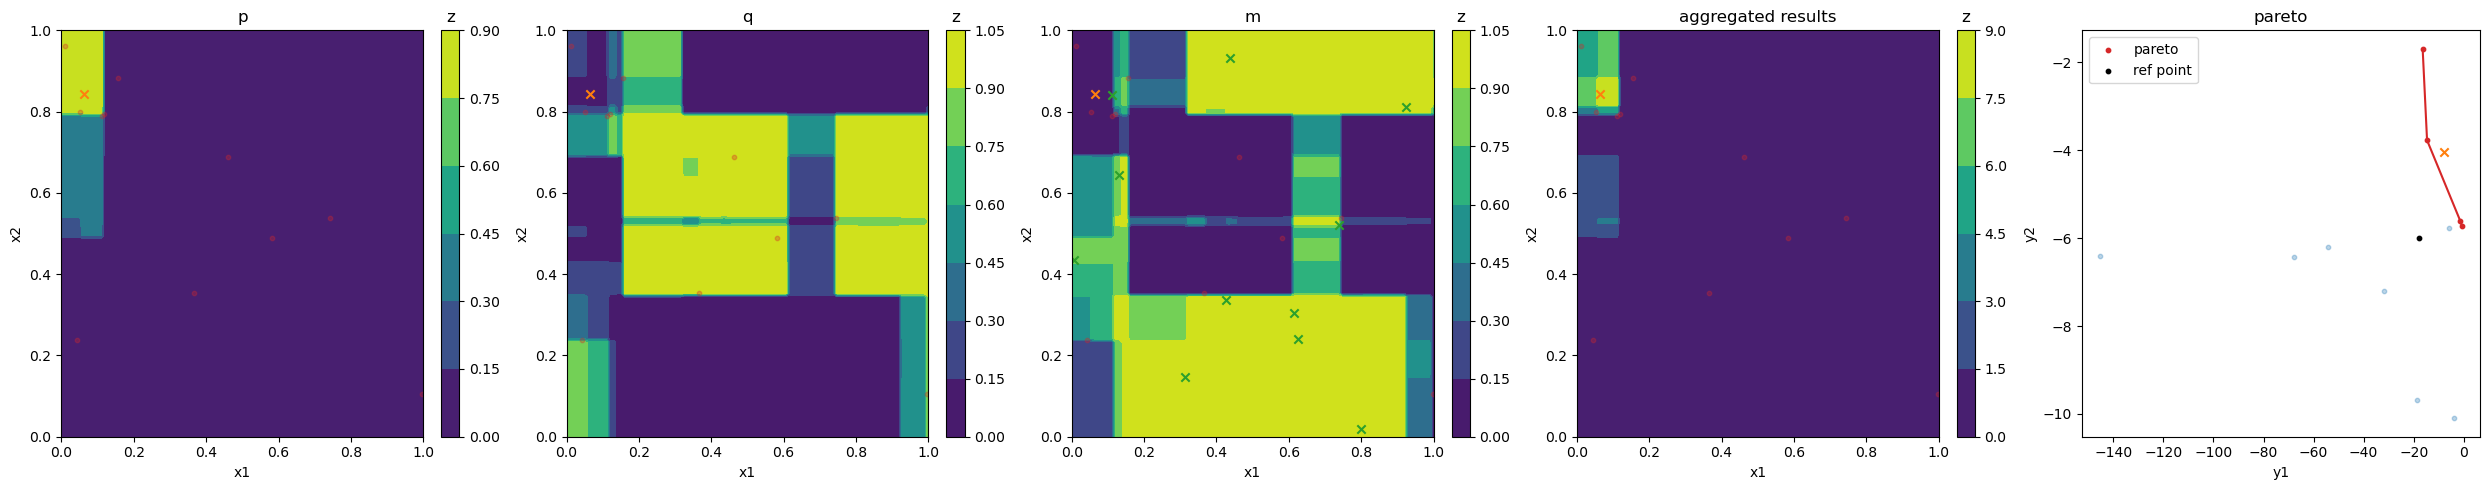

Iteration 6
pareto hv: 27.016311319962316
shell hv: 2.9556086191068442
hv ratio: 0.10940089430058311


100%|██████████| 1000/1000 [00:01<00:00, 590.06it/s]
2024-06-04 15:30:36,496 | Model fitting takes 1.72s
2024-06-04 15:30:36,503 | Optimizing the acquisition function takes 0.01s


total variance: 16.503221756271774
local variance: 23.50904619919682
variance ratio: 1.4245125313342286


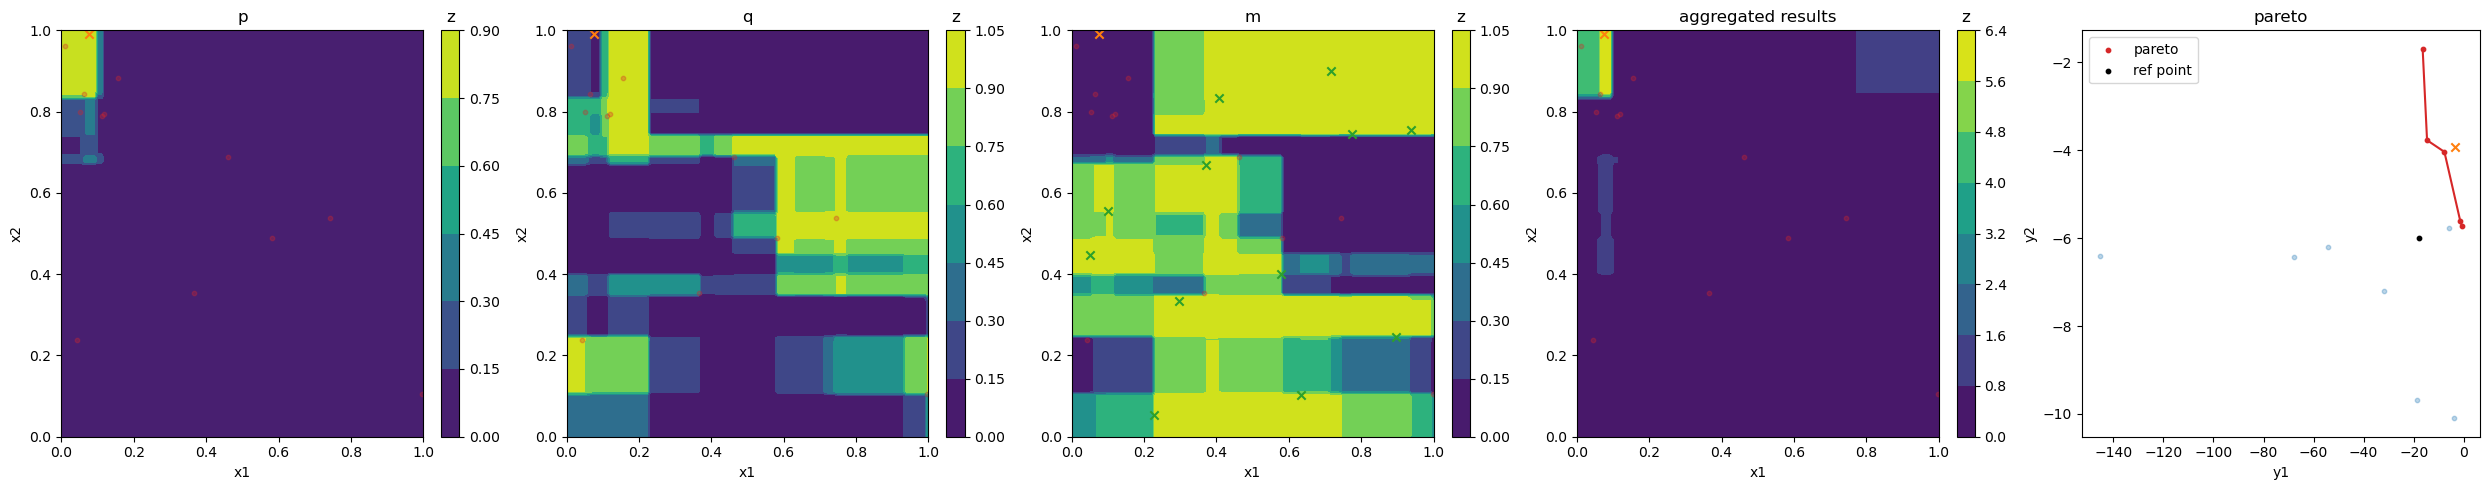

Iteration 7
pareto hv: 35.110496786286944
shell hv: 20.630491648028357
hv ratio: 0.5875875745536582


100%|██████████| 1000/1000 [00:01<00:00, 623.08it/s]
2024-06-04 15:30:38,916 | Model fitting takes 1.63s
2024-06-04 15:30:38,922 | Optimizing the acquisition function takes 0.00s


total variance: 147.18123887911133
local variance: 80.35728006820032
variance ratio: 0.5459750215460716


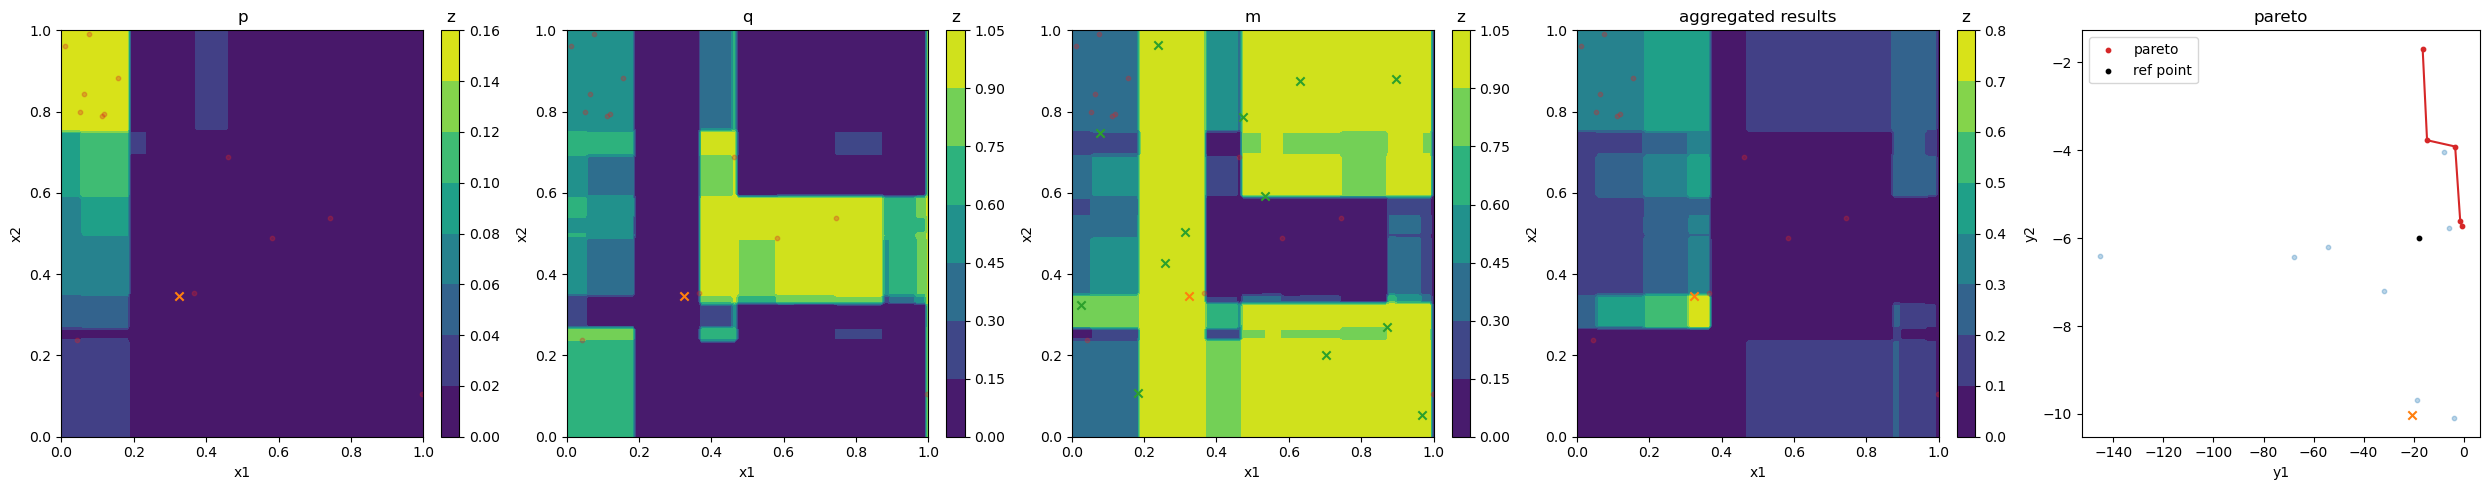

Iteration 8
pareto hv: 35.110496786286944
shell hv: 20.630491648028357
hv ratio: 0.5875875745536582


100%|██████████| 1000/1000 [00:01<00:00, 551.95it/s]
2024-06-04 15:30:41,743 | Model fitting takes 1.83s
2024-06-04 15:30:41,749 | Optimizing the acquisition function takes 0.00s


total variance: 142.9400072110969
local variance: 66.30002845832192
variance ratio: 0.46383115372597256


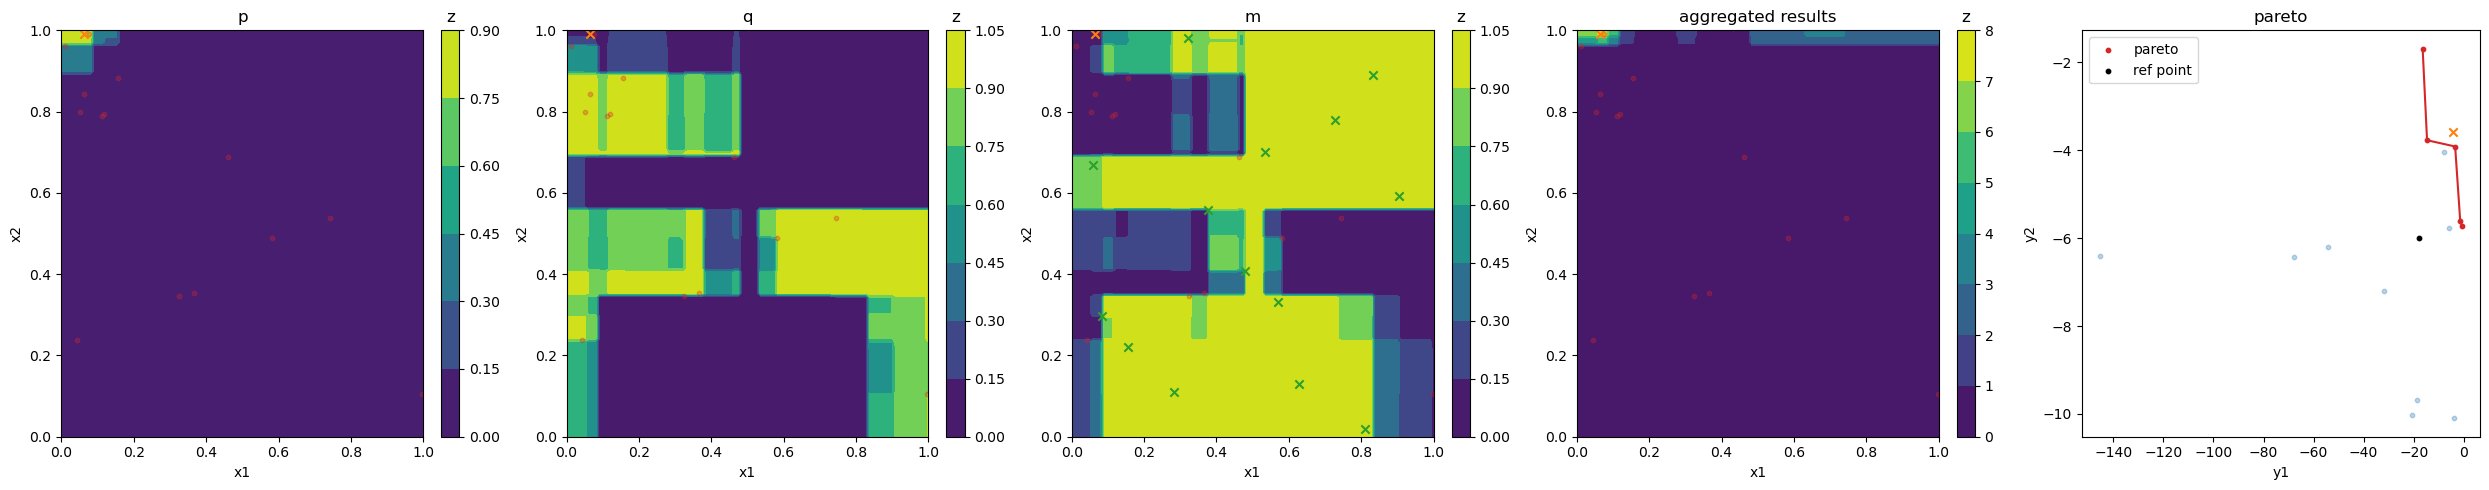

Iteration 9
pareto hv: 39.01469196042976
shell hv: 21.515274130783634
hv ratio: 0.5514659490995155


100%|██████████| 1000/1000 [00:01<00:00, 576.65it/s]
2024-06-04 15:30:44,320 | Model fitting takes 1.76s
2024-06-04 15:30:44,329 | Optimizing the acquisition function takes 0.01s


total variance: 46.22539211068459
local variance: 3.0653523238607736
variance ratio: 0.06631317083305487


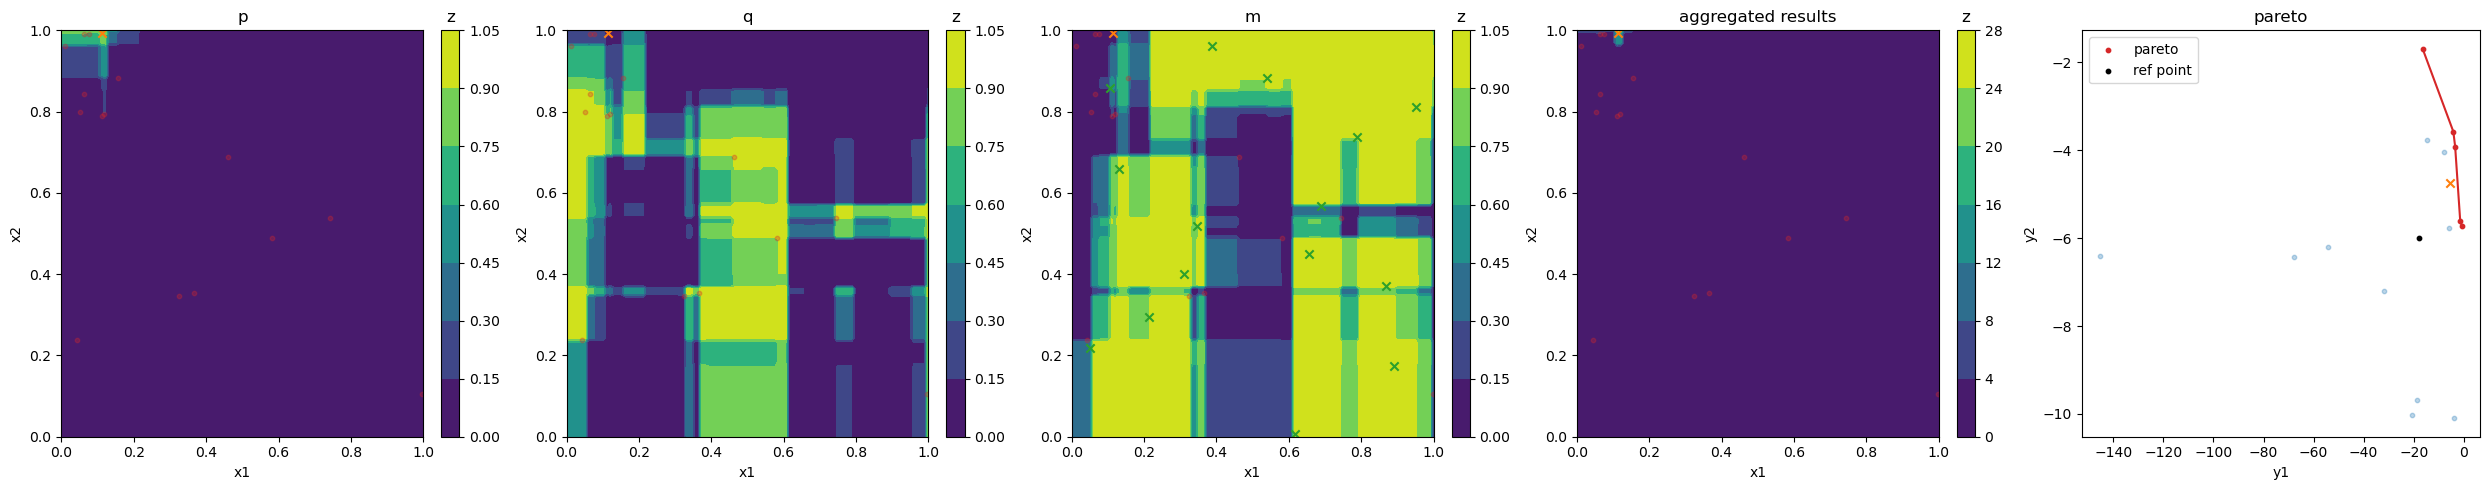

Iteration 10
pareto hv: 39.01469196042976
shell hv: 23.767125377299784
hv ratio: 0.6091839812910824


100%|██████████| 1000/1000 [00:01<00:00, 553.07it/s]
2024-06-04 15:30:46,993 | Model fitting takes 1.83s
2024-06-04 15:30:47,000 | Optimizing the acquisition function takes 0.01s


total variance: 20.192795241921434
local variance: 3.065352323860772
variance ratio: 0.15180425924871063


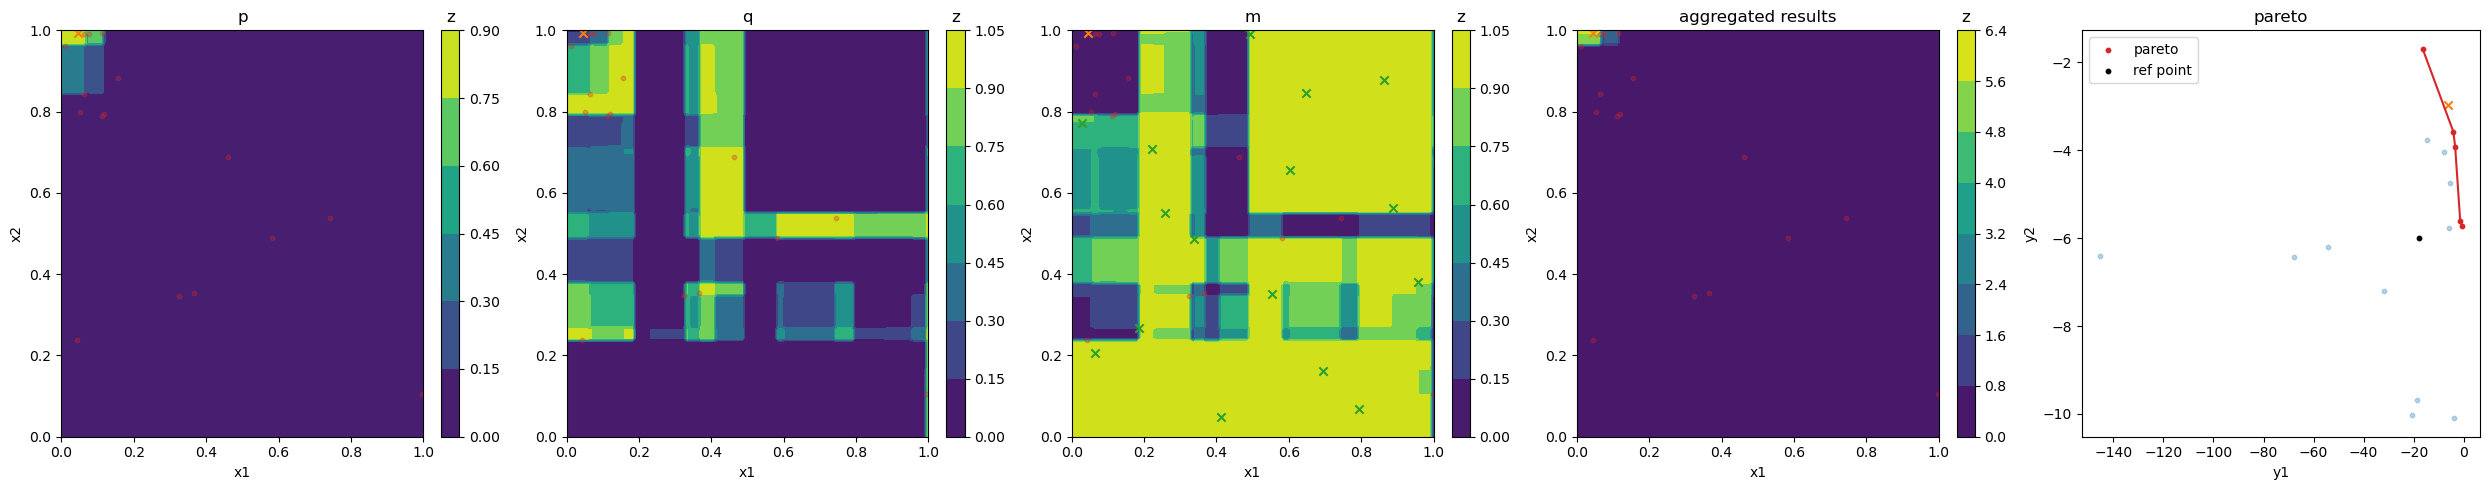

Iteration 11
pareto hv: 45.00241978626847
shell hv: 23.767125377299784
hv ratio: 0.528129942571484


100%|██████████| 1000/1000 [00:01<00:00, 570.72it/s]
2024-06-04 15:30:49,597 | Model fitting takes 1.77s
2024-06-04 15:30:49,604 | Optimizing the acquisition function takes 0.01s


total variance: 21.299964248931893
local variance: 4.797718495203249
variance ratio: 0.2252453778387837


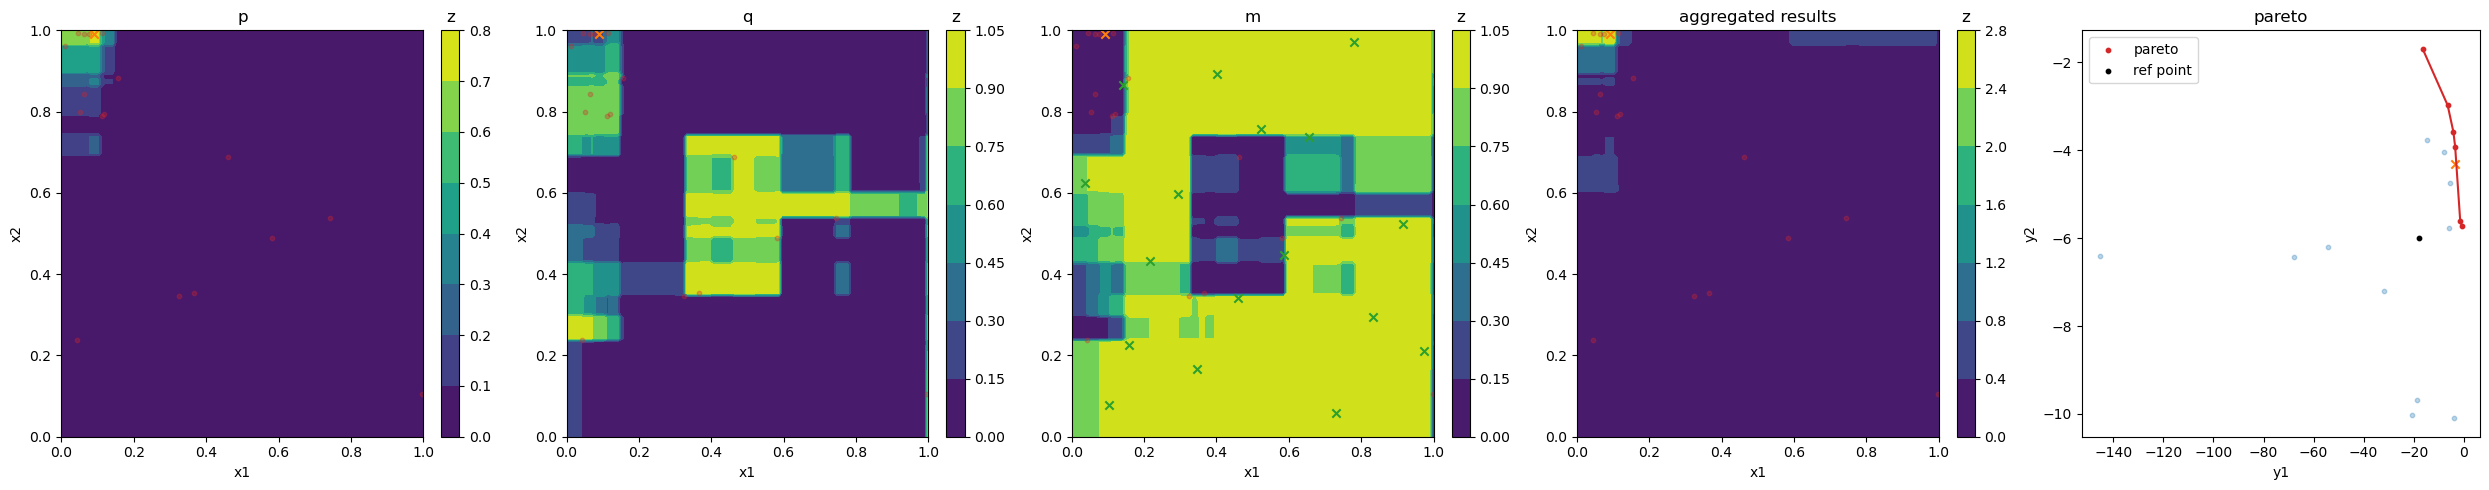

Iteration 12
pareto hv: 45.052482989372365
shell hv: 23.767125377299784
hv ratio: 0.5275430742164937


100%|██████████| 1000/1000 [00:01<00:00, 542.02it/s]
2024-06-04 15:30:52,528 | Model fitting takes 1.87s
2024-06-04 15:30:52,536 | Optimizing the acquisition function takes 0.01s


total variance: 20.242615958625706
local variance: 5.1388704358007775
variance ratio: 0.2538639495164172


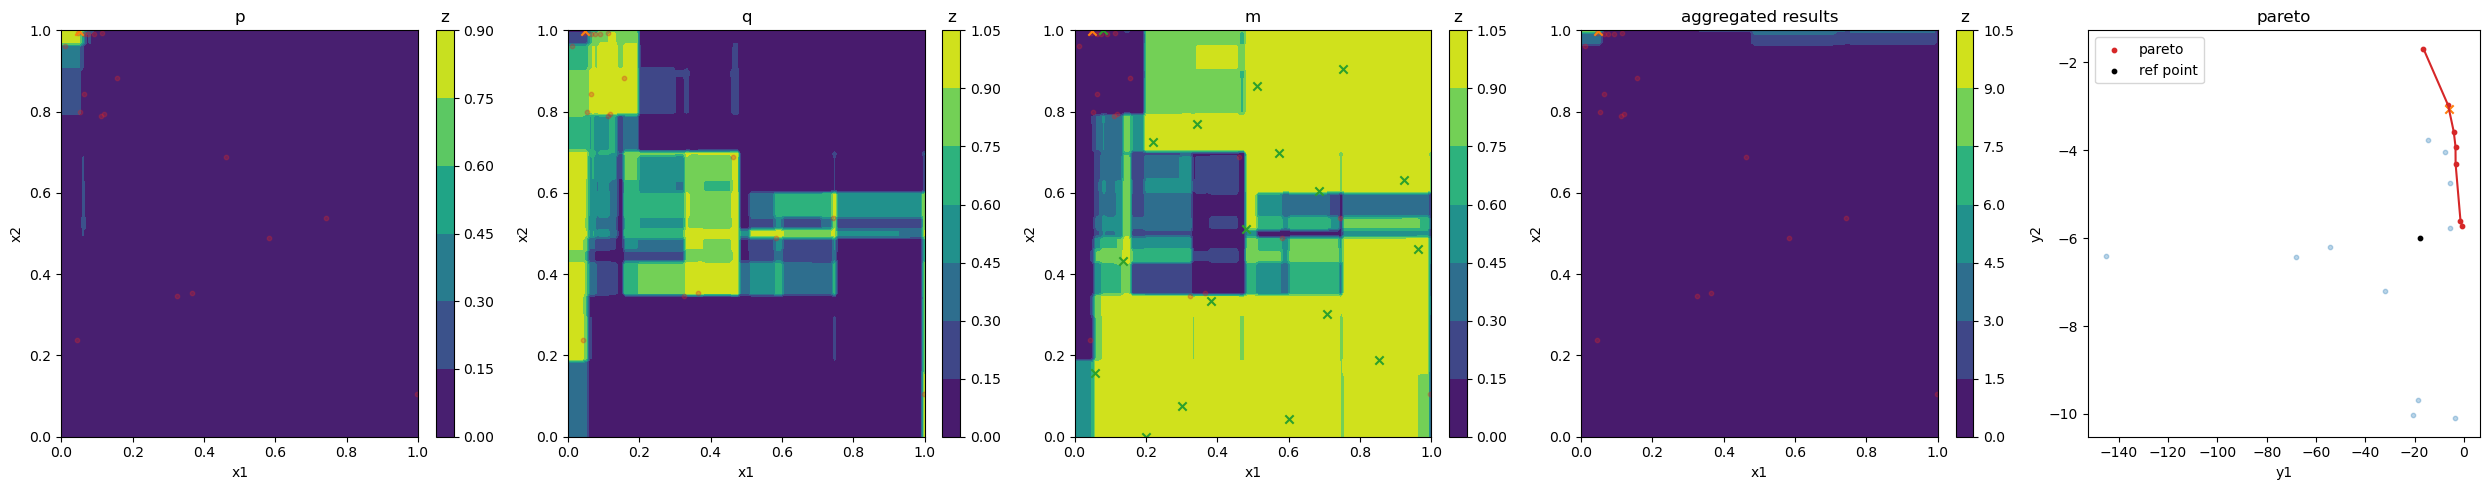

Iteration 13
pareto hv: 45.298311054248174
shell hv: 23.767125377299784
hv ratio: 0.5246801663054688


100%|██████████| 1000/1000 [00:02<00:00, 490.33it/s]
2024-06-04 15:30:55,400 | Model fitting takes 2.06s
2024-06-04 15:30:55,406 | Optimizing the acquisition function takes 0.01s


total variance: 15.944555781707654
local variance: 0.4777310616521205
variance ratio: 0.029962017643677227


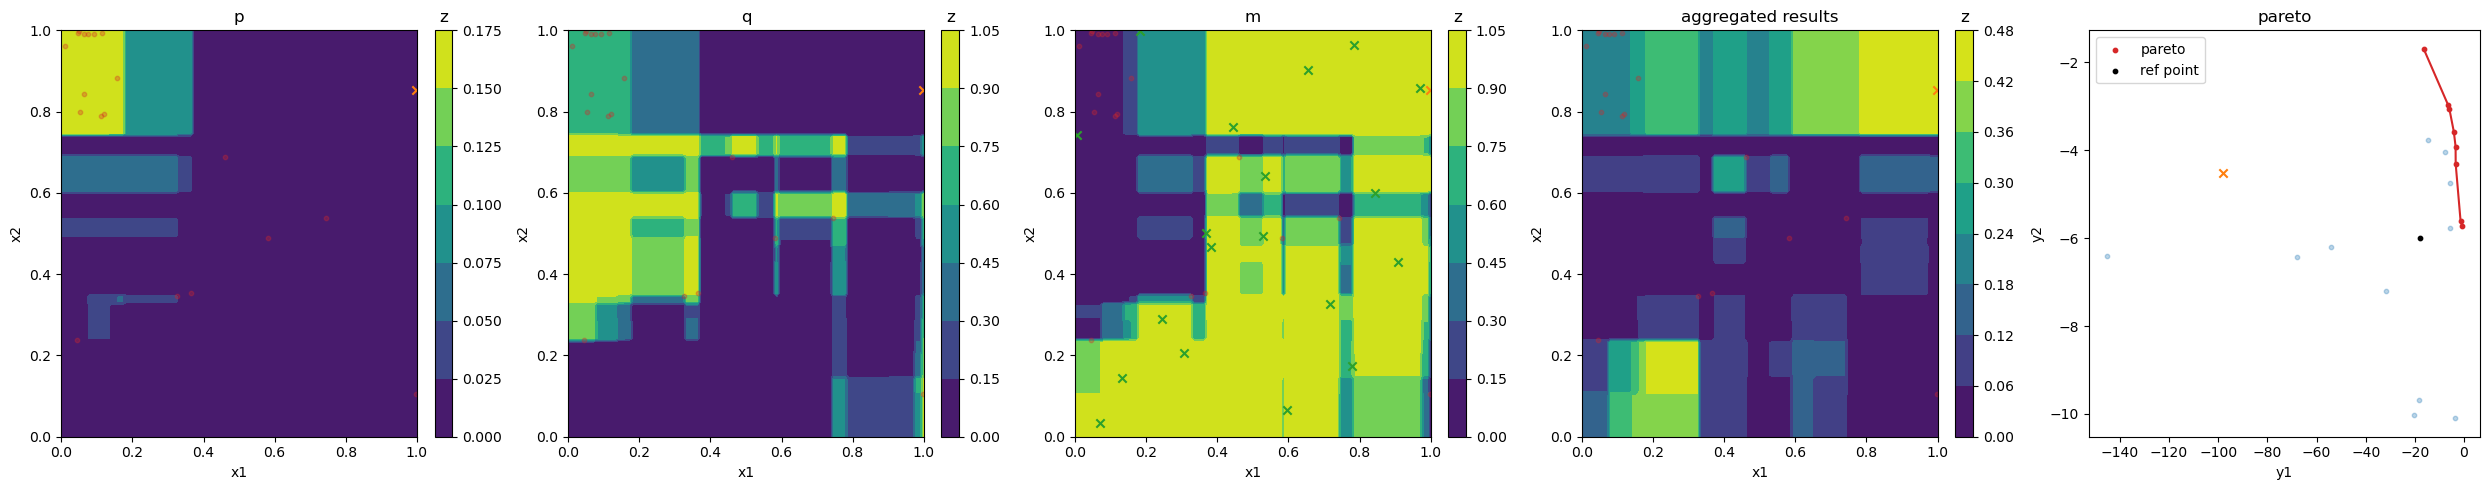

Iteration 14
pareto hv: 45.298311054248174
shell hv: 23.767125377299784
hv ratio: 0.5246801663054688


100%|██████████| 1000/1000 [00:01<00:00, 519.12it/s]
2024-06-04 15:30:58,196 | Model fitting takes 1.95s
2024-06-04 15:30:58,204 | Optimizing the acquisition function takes 0.01s


total variance: 16.183870009041755
local variance: 0.43768288281822776
variance ratio: 0.027044389418210787


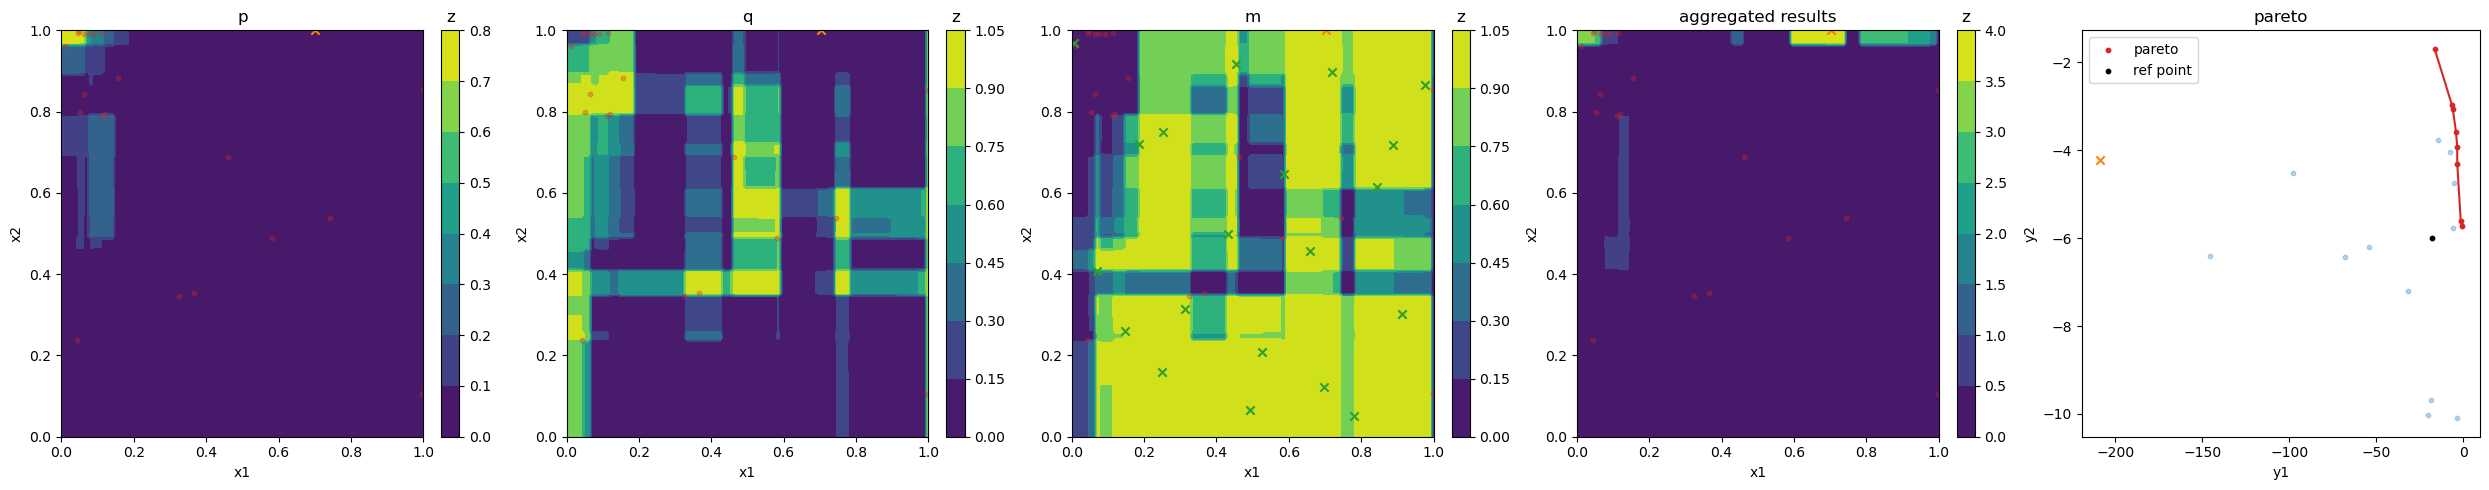

Iteration 15
pareto hv: 45.298311054248174
shell hv: 23.767125377299784
hv ratio: 0.5246801663054688


100%|██████████| 1000/1000 [00:01<00:00, 511.90it/s]
2024-06-04 15:31:01,066 | Model fitting takes 1.97s
2024-06-04 15:31:01,072 | Optimizing the acquisition function takes 0.00s


total variance: 16.301674117923135
local variance: 0.43768288281822776
variance ratio: 0.026848953037100057


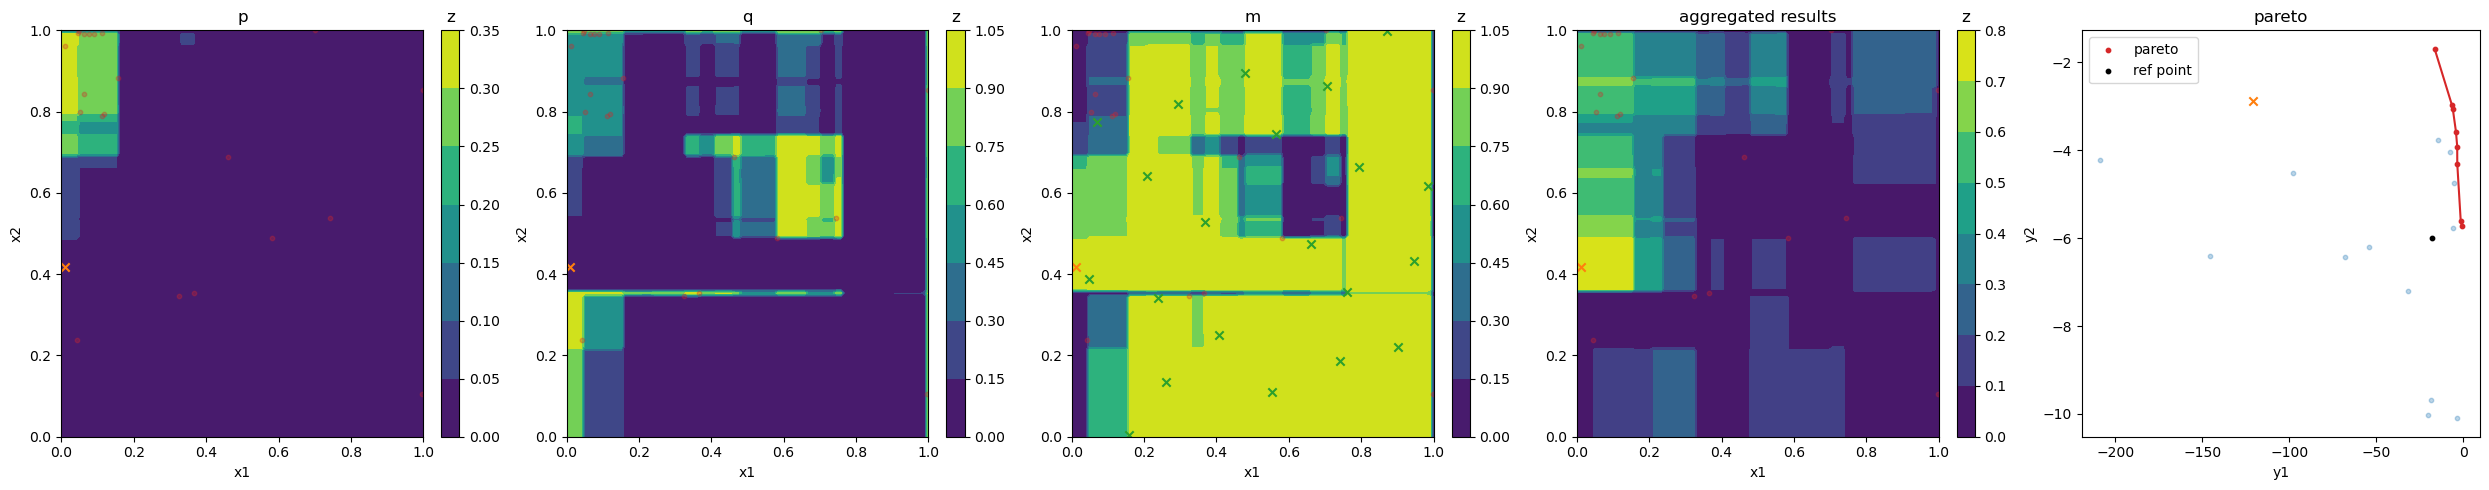

Iteration 16
pareto hv: 45.298311054248174
shell hv: 23.767125377299784
hv ratio: 0.5246801663054688


100%|██████████| 1000/1000 [00:02<00:00, 484.05it/s]
2024-06-04 15:31:04,149 | Model fitting takes 2.09s
2024-06-04 15:31:04,157 | Optimizing the acquisition function takes 0.01s


total variance: 16.3279992545878
local variance: 0.43768288281822776
variance ratio: 0.026805665286593436


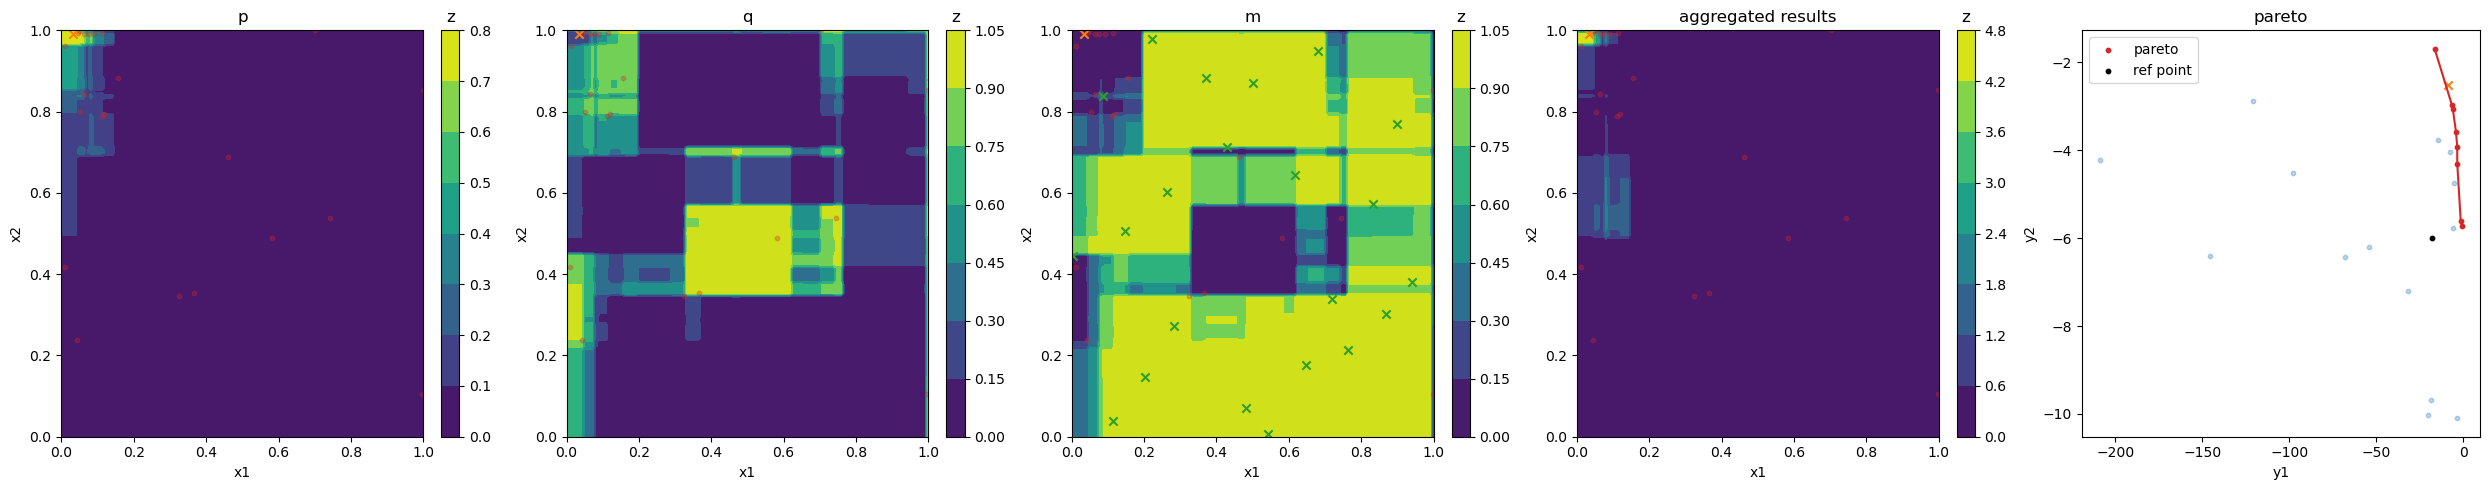

Iteration 17
pareto hv: 48.73979424836217
shell hv: 23.767125377299784
hv ratio: 0.48763286230118713


100%|██████████| 1000/1000 [00:02<00:00, 459.97it/s]
2024-06-04 15:31:07,226 | Model fitting takes 2.20s
2024-06-04 15:31:07,235 | Optimizing the acquisition function takes 0.01s


total variance: 17.33075285034415
local variance: 1.2664474166981052
variance ratio: 0.07307515303196747


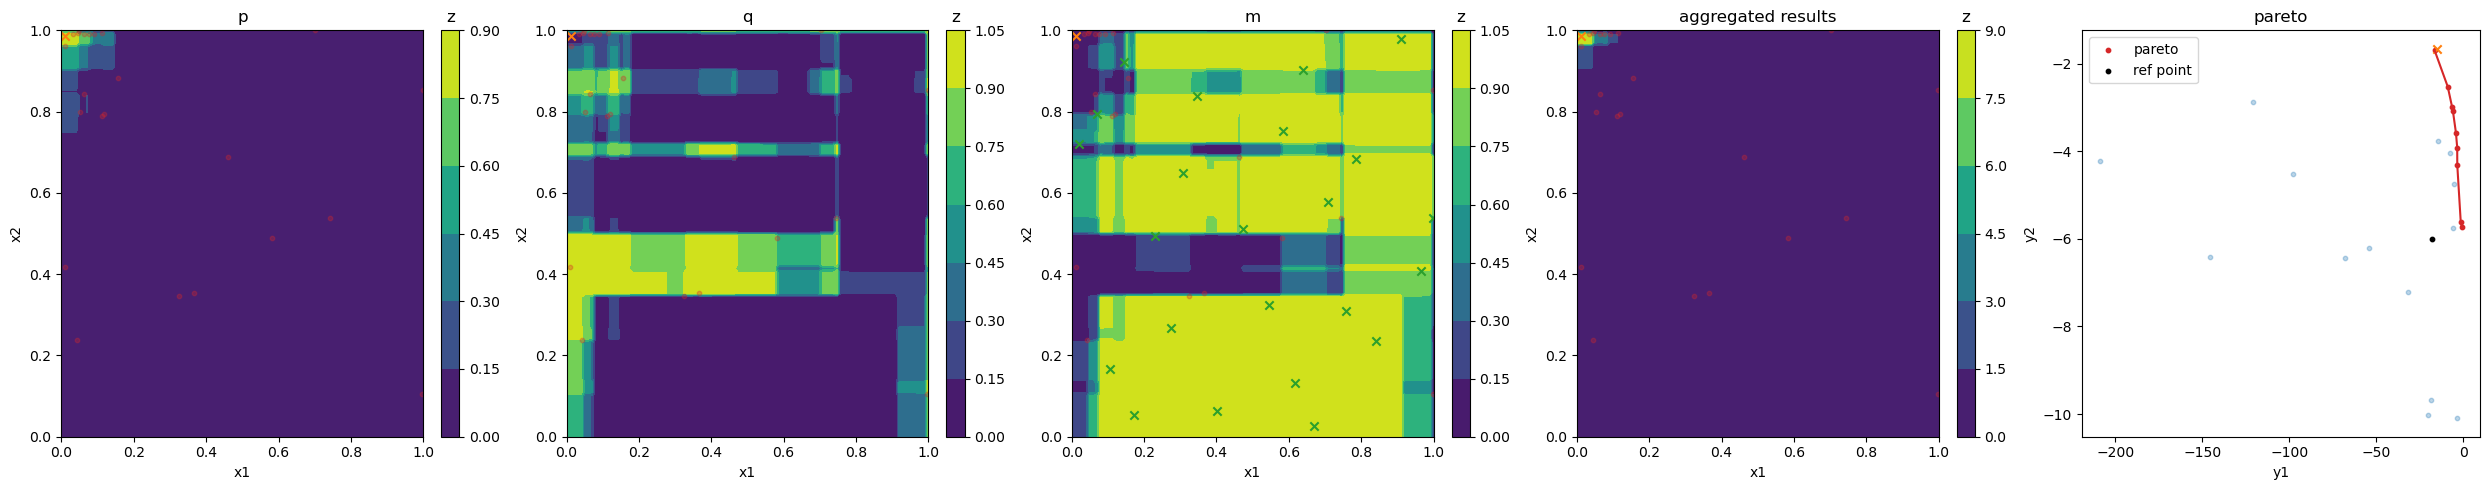

Iteration 18
pareto hv: 50.190882510039565
shell hv: 27.04234853782914
hv ratio: 0.5387900587804951


100%|██████████| 1000/1000 [00:02<00:00, 498.69it/s]
2024-06-04 15:31:10,161 | Model fitting takes 2.03s
2024-06-04 15:31:10,169 | Optimizing the acquisition function takes 0.01s


total variance: 17.04481718310672
local variance: 1.2862291924119347
variance ratio: 0.07546160094264483


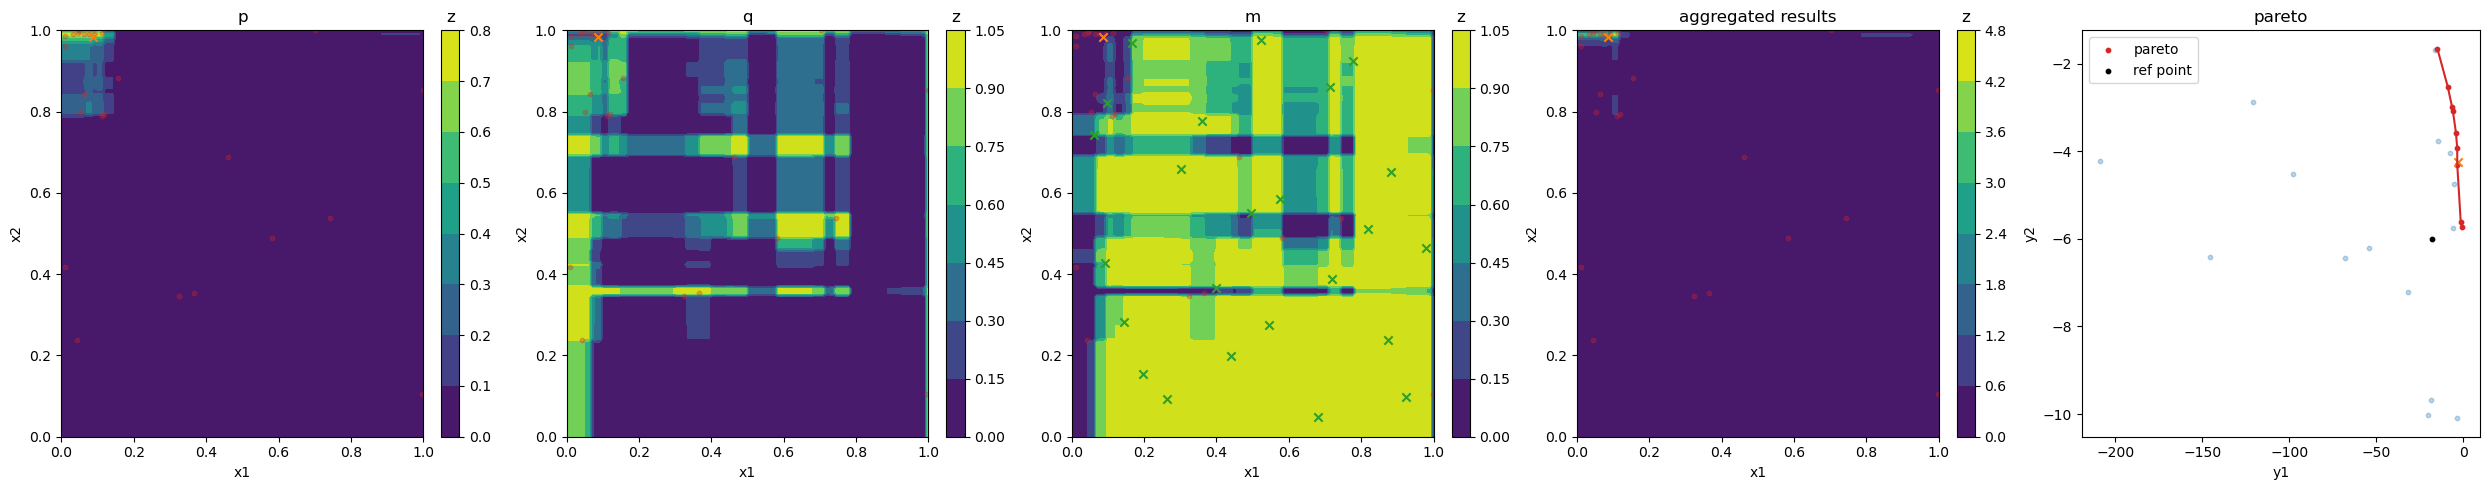

Iteration 19
pareto hv: 50.7185272831726
shell hv: 31.633133652736262
hv ratio: 0.6236997670717365


100%|██████████| 1000/1000 [00:02<00:00, 480.90it/s]
2024-06-04 15:31:13,137 | Model fitting takes 2.11s
2024-06-04 15:31:13,147 | Optimizing the acquisition function takes 0.01s


total variance: 159.11656599379498
local variance: 1.2460229091234574
variance ratio: 0.007830881098653476


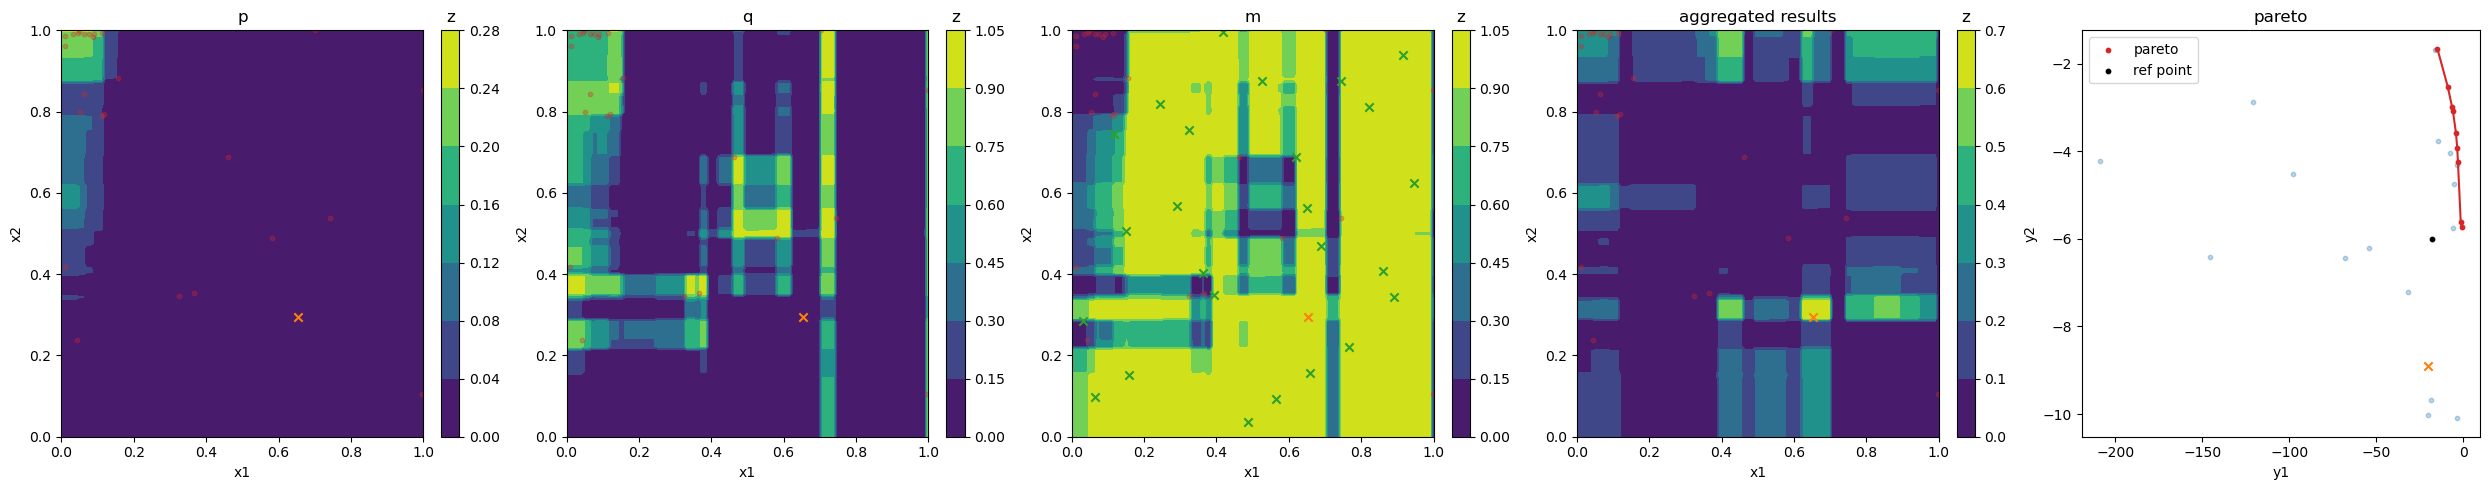

In [10]:
optimizer = MBORE_MDRE_AUX_HV_09(
    problem=problem, 
)

for n in range(20):
    print(f"Iteration {n}")

    pareto = is_non_dominated(y_obs)
    bd = DominatedPartitioning(ref_point=problem.ref_point, Y=y_obs)
    nbd = FastNondominatedPartitioning(ref_point=problem.ref_point, Y=y_obs)
    u, l = bd.hypercell_bounds
    u_nbd, _ = nbd.hypercell_bounds

    boxes = [Rectangle(
        l_point.cpu(),
        *(u_point - l_point).cpu(),
    ) for l_point, u_point in zip(l, u)]


    new_x = optimizer.observe_and_suggest(x_obs, y_obs, S=1000)
    new_y = problem(new_x)

    preds_p = torch.empty(0, **tkwargs)
    preds_q = torch.empty(0, **tkwargs)
    preds_m = torch.empty(0, **tkwargs)
    preds = torch.empty(0, **tkwargs)
    i = 0

    with torch.no_grad():
        # MLP
        # pred_logits = optimizer.clf(x_cands)
        # acf_mdre = torch.nn.functional.softmax(pred_logits, dim=-1)
    
        # random forest
        acf_mdre = np.clip(optimizer.clf.predict_proba(x_cands), a_min=1e-4, a_max=None)
        acf_mdre = torch.from_numpy(acf_mdre).to(**tkwargs)

        dr_mdre = acf_mdre[:, 0] / acf_mdre[:, 1]
        preds = torch.cat([preds, dr_mdre])
        preds_p = torch.cat([preds_p, acf_mdre[:, 0]])
        preds_q = torch.cat([preds_q, acf_mdre[:, 1]])
        preds_m = torch.cat([preds_m, acf_mdre[:, 2]])

    # plot aggregated results
    fig = plt.figure(figsize=(25, 5))

    ax_p = plt.subplot2grid((1, 5), (0, 0))
    plot_input_space(xx, yy, x_obs, preds_p, fig, ax_p, title="p")
    ax_p.scatter(*new_x.t(), marker='x', color='tab:orange', label='candidates')
    ax_q = plt.subplot2grid((1, 5), (0, 1))
    plot_input_space(xx, yy, x_obs, preds_q, fig, ax_q, title="q")
    ax_q.scatter(*new_x.t(), marker='x', color='tab:orange', label='candidates')
    ax_m = plt.subplot2grid((1, 5), (0, 2))
    plot_input_space(xx, yy, x_obs, preds_m, fig, ax_m, title="m")
    ax_m.scatter(*new_x.t(), marker='x', color='tab:orange', label='candidates')
    ax_m.scatter(*optimizer.x_m.t(), marker='x', color='tab:green', label='candidates')

    ax_agg = plt.subplot2grid((1, 5), (0, 3))
    plot_input_space(xx, yy, x_obs, preds, fig, ax_agg, title="aggregated results")
    ax_agg.scatter(*new_x.t(), marker='x', color='tab:orange', label='candidates')

    ax_agg_p = plt.subplot2grid((1,  5), (0, 4))
    plot_pareto_space(y_obs, pareto, l, u_nbd, ax_agg_p, title='pareto')
    ax_agg_p.scatter(*new_y.t(), marker='x', color='tab:orange', label='candidates')

    plt.tight_layout()
    plt.show()
    x_obs = torch.cat([x_obs, new_x])
    y_obs = torch.cat([y_obs, new_y])

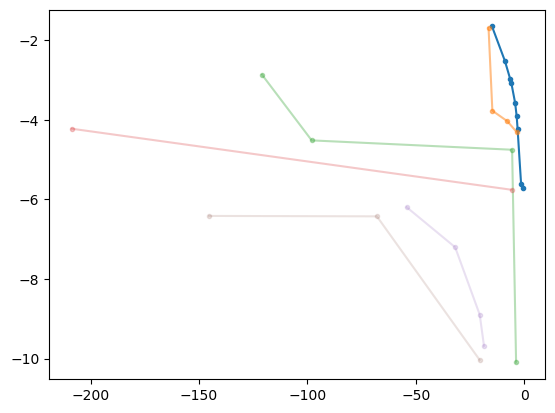

In [11]:
import pygmo as pg

y_obs = y_obs.numpy()
ndf, _, _, _ = pg.fast_non_dominated_sorting(-y_obs)

for n, shell in enumerate(ndf, start=1):
    sorted_idx = np.argsort(y_obs[shell][:, 0])
    plt.plot(
        y_obs[shell][sorted_idx][:, 0],
        y_obs[shell][sorted_idx][:, 1],
        '-o',
        markersize=3,
        alpha=1/n
    )